In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path
from pprint import pprint
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mycode
from repo import REPO
from ml_utilities.output_loader.result_loader import SweepResult, JobResult
from ml_utilities.output_loader import create_job_output_loader
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values

# 24-cf10-resnet subclass long

**RERUN 22**: This time we run the pre-training for more steps. In the previous experiment we did not see accuracy on the transfer task going down. 

## A. Experiment config

In [2]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [0]
  runs_per_gpu: 1
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

# sweep:
#   type: grid
#   axes: 
#   - parameter: data.dataset_transforms.enable_transforms
#     vals: [True, False]
    
start_num: 0_pret

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '24.0'
    experiment_type: startnum_${startnum}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet-subcl-long
    experiment_dir: null
    experiment_notes: null
    seed: 0
    gpu_id: 0
    job_name: null
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}
  model:
    name: resnet
    model_kwargs:
      in_channels: 3
      act_fn: relu
      residual_option: B
      input_layer_config:
        kernel_size: 3
        out_channels: 16
        bias: false
        batch_norm: true
        stride: 1
        padding: 1
      resnet_blocks_config:
      - out_channels: 16
        num_residual_blocks: 3
      - out_channels: 32
        num_residual_blocks: 3
      - out_channels: 64
        num_residual_blocks: 3
      linear_output_units:
      - 3
      model_initializer: kaiming_normal
      batchnorm_initializer: uniform
  trainer:
    training_setup: supervised_cov_analysis
    n_steps: 100e3
    log_train_step_every: 1000
    log_additional_train_step_every: 1000
    val_every: 500
    save_every: 10e3
    early_stopping_patience: 100e3
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: SGD
      optimizer_kwargs:
        lr: 0.1
        momentum: 0.9
        weight_decay: 0.0001
      lr_scheduler_name: MultiStepLR
      lr_scheduler_kwargs:
        milestones: [40e3, 60e3, 80e3]
        gamma: 0.1
    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4
    enable_cov_analysis: false
    cov_analysis_args:
      num_batches: 25
      use_tqdm: false
  data:
    dataset: cifar10
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
    train_split_transforms:
      image_transforms:
      - RandomHorizontalFlip
      - RandomCrop:
          size: 32
          padding: 4
      tensor_transforms: null
      joint_tensor_transforms: null
      enable_transforms: true
    use_classes:
    - automobile
    - dog
    - horse
"""
cfg = OmegaConf.create(config_yaml)

In [3]:
run_command = REPO.create_experiment(cfg, override=False)
print(run_command)

python run.py --config-name cifar10-24.0.0_pret-resnet-subcl-long.yaml


In [4]:
jres1 = REPO.get_output_loader(cfg)
print(jres1)

/system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-24.0.0_pret-resnet-subcl-long--230215_092215


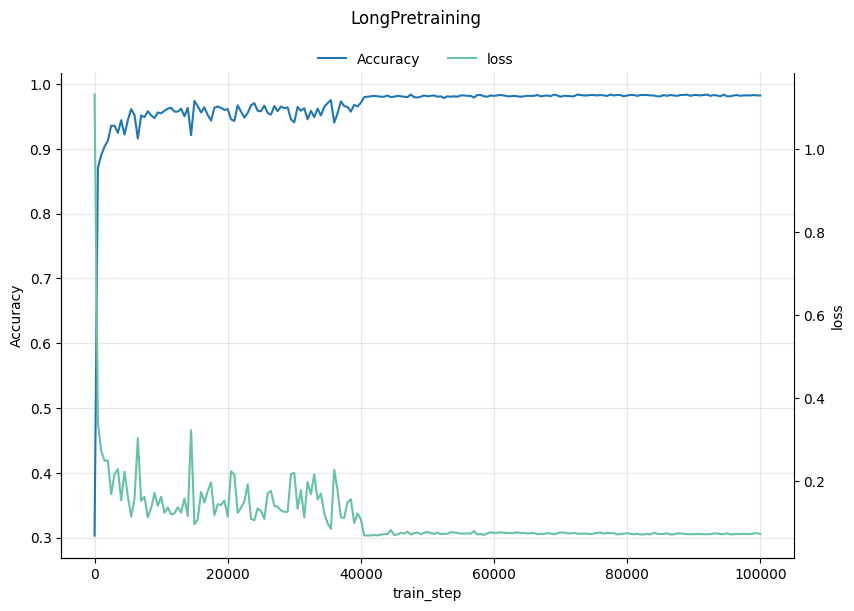

In [13]:
f = plot_data_log_values(data_log_df=jres1.get_data_log('val'), x_axis='train_step', y_axis_left='Accuracy', y_axis_right='loss', title='LongPretraining', savefig=True)

## B. Analysis 1

In [6]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [0,1,2,3]
  runs_per_gpu: 2
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler
seeds:
- 0

sweep:
  type: grid
  axes: 
  - parameter: data.use_classes
    vals:
    - ['frog', 'truck', 'airplane']
    - ['ship', 'bird', 'deer']
    - ['frog', 'bird', 'deer']
    - ['truck', 'bird', 'deer']
    - ['ship', 'cat', 'truck']
  - parameter: init_model_step
    vals: [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000]
  # - parameter: data.dataset_split.restrict_n_samples_train_task
  #   vals: [500, 2000, 5000, 10000, 20000]
  # - parameter: trainer.optimizer_scheduler.optimizer_kwargs.lr
  #   vals: [0.1, 0.01, 0.001]
  

start_num: 0_finet

config:
  experiment_data:
    entity: fslgroup 
    project_name: tflearning
    experiment_tag: '24.1'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet-subcl-long
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 0
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}
      mode: offline
    watch:
      log: null
      log_freq: null
      
  init_model_step: 15000
  model:
    name: resnet
    model_kwargs:
      in_channels: 3
      act_fn: relu
      residual_option: B
      input_layer_config:
        kernel_size: 3
        out_channels: 16
        bias: false
        batch_norm: true
        stride: 1
        padding: 1
      resnet_blocks_config:
        - out_channels: 16
          num_residual_blocks: 3
        - out_channels: 32
          num_residual_blocks: 3
        - out_channels: 64
          num_residual_blocks: 3
      linear_output_units:
        - 3
      model_initializer: kaiming_normal
      batchnorm_initializer: uniform
    init_model: /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-24.0.0_pret-resnet-subcl-long--230215_092215/checkpoints/checkpoint-train_step--${config.init_model_step}.p
    

  
  trainer:
    training_setup: supervised_cov_analysis
    n_steps: 20e3
    log_train_step_every: 1000
    log_additional_train_step_every: 1000
    val_every: 200
    save_every: 64000.0
    early_stopping_patience: 64000.0
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: SGD
      optimizer_kwargs:
        lr: 0.1
        momentum: 0.9
        weight_decay: 0.0001
      lr_scheduler_name: MultiStepLR
      lr_scheduler_kwargs:
        milestones: [10e3, 15e3]
        gamma: 0.1
    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4

    enable_cov_analysis: False #True
    cov_analysis_args:
      num_batches: 25
      use_tqdm: False
  
  data:
    dataset: cifar10
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
      restrict_n_samples_train_task: 2000
    train_split_transforms:
      image_transforms:
      - RandomHorizontalFlip
      - RandomCrop:
          size: 32
          padding: 4
      tensor_transforms: null
      joint_tensor_transforms: null
      enable_transforms: true
    use_classes:
    - automobile
    - dog 
    - horse
"""
cfg = OmegaConf.create(config_yaml)

In [7]:
run_command = REPO.create_experiment(cfg, override=False)
print(run_command)

python run_sweep.py --config-name cifar10-24.1.0_finet-resnet-subcl-long.yaml


In [8]:
swres1 = REPO.get_output_loader(cfg)
print(swres1)

Exp. Tag(start_num): 24.1(0_finet)
Exp. Name: cifar10-24.1.0_finet-resnet-subcl-long
Training setup: supervised_cov_analysis
Model name: resnet
Dataset name: cifar10
Sweep type: grid
  data.use_classes: [['frog', 'truck', 'airplane'], ['ship', 'bird', 'deer'], ['frog', 'bird', 'deer'], ['truck', 'bird', 'deer'], ['ship', 'cat', 'truck']]
  init_model_step: [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
Seeds: [0]
Num. jobs: 55
Config updated: 2023-02-15 11:42:09
Sweep started:  2023-02-15 11:42:46



In [9]:
sw_summary = swres1.get_summary(log_source='val', row_sel=('train_step', [1000, 5000, 10000]), col_sel='Accuracy')

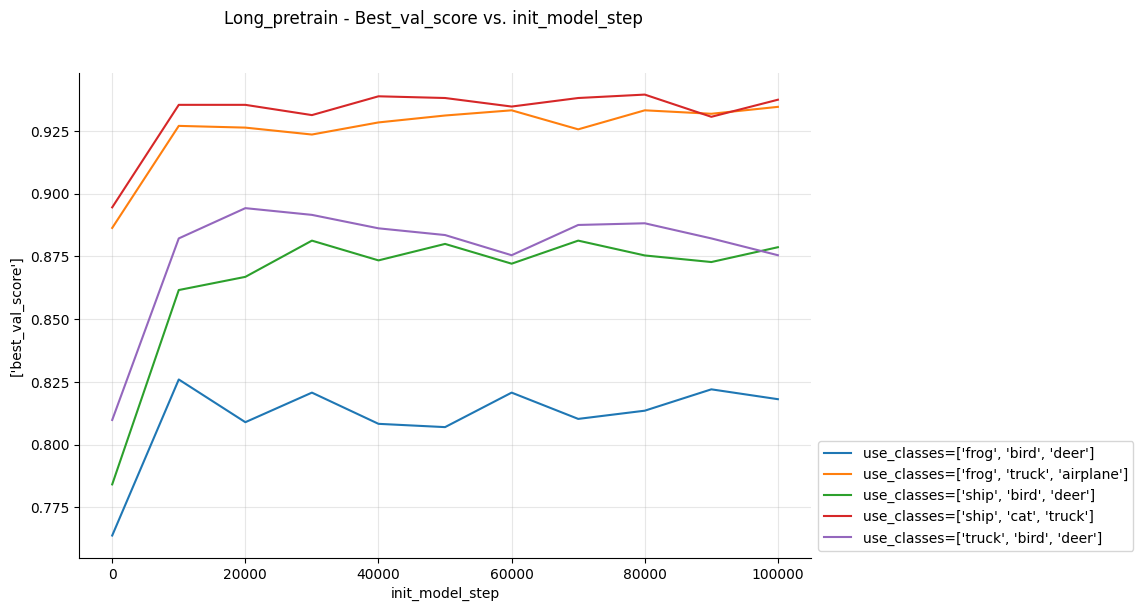

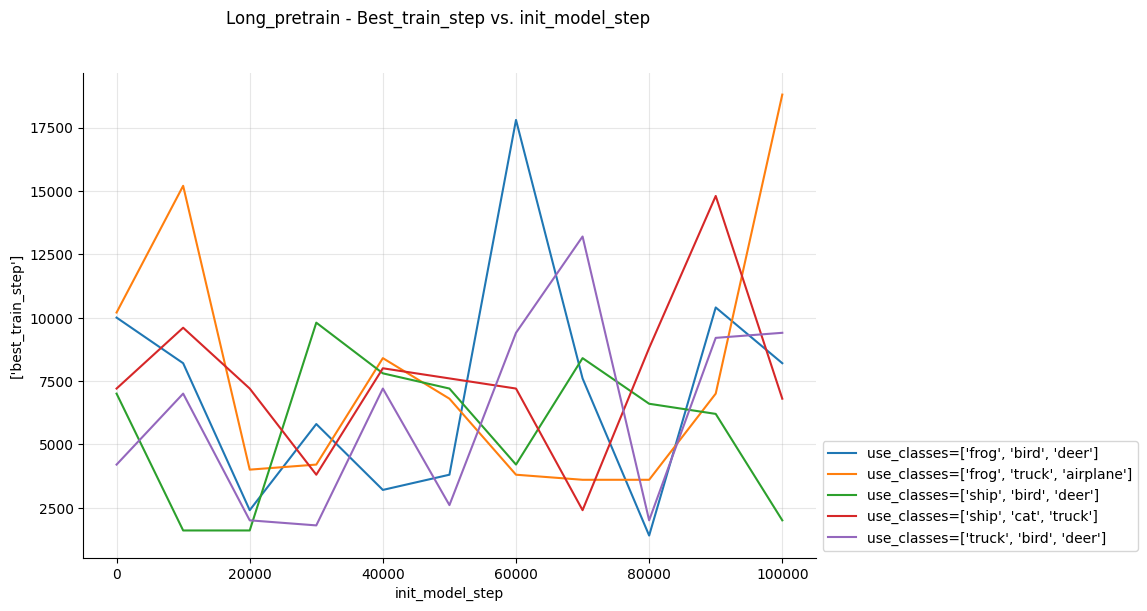

In [14]:
p1 = plot_sweep_summary(sw_summary, x_axis='init_model_step', y_axis='best_val_score', compare_parameter='data.use_classes', title='Long_pretrain - Best_val_score vs. init_model_step', savefig=True)
p1 = plot_sweep_summary(sw_summary, x_axis='init_model_step', y_axis='best_train_step', compare_parameter='data.use_classes', title='Long_pretrain - Best_train_step vs. init_model_step', savefig=False)